# Civil Service Survival Analysis


In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lifelines as sa

from pathlib import Path
from lifelines import KaplanMeierFitter
from lifelines.utils import concordance_index, k_fold_cross_validation
from lifelines.plotting import plot_lifetimes
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold


# Import Dummy Data

In [36]:
data_path = 'data/dummy_data.csv'

In [37]:
data = pd.read_csv(data_path, index_col=0)

In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 579 entries, 0 to 582
Data columns (total 12 columns):
age                           579 non-null int64
gender                        579 non-null int64
total_bilirubin               579 non-null float64
direct_bilirubin              579 non-null float64
alkaline_phosphotase          579 non-null int64
alamine_aminotransferase      579 non-null int64
aspartate_aminotransferase    579 non-null int64
total_proteins                579 non-null float64
albumin                       579 non-null float64
albumin_and_globulin_ratio    579 non-null float64
liver_patient                 579 non-null int64
dummy_category                579 non-null object
dtypes: float64(5), int64(6), object(1)
memory usage: 58.8+ KB


In [39]:
target_variable = 'age'
features = [col for col in data.columns if col is not target_variable]

In [40]:
features

['age',
 'gender',
 'total_bilirubin',
 'direct_bilirubin',
 'alkaline_phosphotase',
 'alamine_aminotransferase',
 'aspartate_aminotransferase',
 'total_proteins',
 'albumin',
 'albumin_and_globulin_ratio',
 'liver_patient',
 'dummy_category']

Stratify based on yes/no liver 

In [41]:
n_folds, cols = 3, features
skf = StratifiedKFold(n_splits=n_folds, shuffle=True)
kfold_indices = list(skf.split(X=data, 
                               y=data['liver_patient']))

In [43]:
data['observed'] = 1

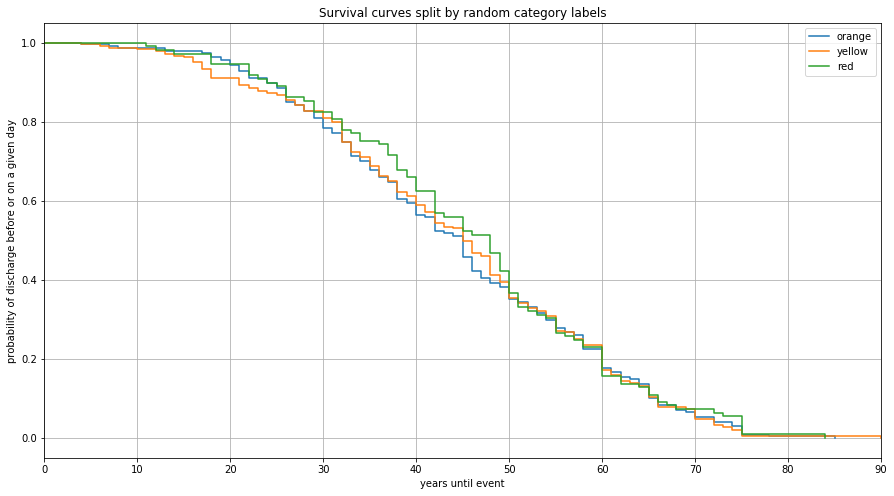

In [46]:
plt.rcParams['figure.figsize'] = 15, 8

ax = -1

for cat in data['dummy_category'].unique():
    kmf = KaplanMeierFitter()
    d = data[data['dummy_category']==cat]
    kmf.fit(d[target_variable], event_observed=d['observed'], label=cat)
    if ax==-1:
        ax=kmf.plot(ci_show=False)
    else:
        kmf.plot(ax=ax, ci_show=False)
plt.ylabel('probability of discharge before or on a given day')
plt.xlabel('years until event')
plt.title(f'Survival curves split by random category labels')
plt.grid()
plt.show()

In [47]:
from lifelines import CoxPHFitter, ExponentialFitter, NelsonAalenFitter

In [49]:
cpf = CoxPHFitter()
cpf.fit(data.drop('dummy_category', axis=1), duration_col='age', event_col='observed')

<lifelines.CoxPHFitter: fitted with 579 observations, 0 censored>

In [50]:
cpf.print_summary()


<lifelines.CoxPHFitter: fitted with 579 observations, 0 censored>
      duration col = 'age'
         event col = 'observed'
number of subjects = 579
  number of events = 579
partial log-likelihood = -3081.13
  time fit was run = 2019-09-19 21:21:23 UTC

---
                            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
gender                     -0.08      0.93      0.10           -0.27            0.12                0.76                1.13
total_bilirubin             0.00      1.00      0.01           -0.02            0.03                0.98                1.03
direct_bilirubin            0.03      1.03      0.03           -0.03            0.09                0.97                1.10
alkaline_phosphotase       -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
alamine_aminotransferase    0.00      1.00      0.00            0.00            0.00                1.00            

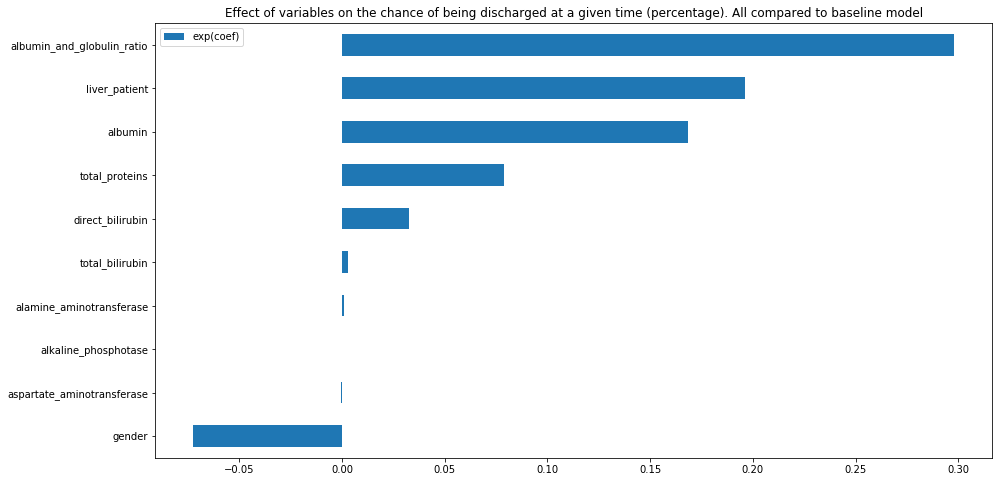

In [51]:
(cpf.summary[['exp(coef)']] - 1).sort_values('exp(coef)').plot.barh()
plt.title('Effect of variables on the chance of being discharged at a given time (percentage). All compared to baseline model')
plt.show()

Use interact with this

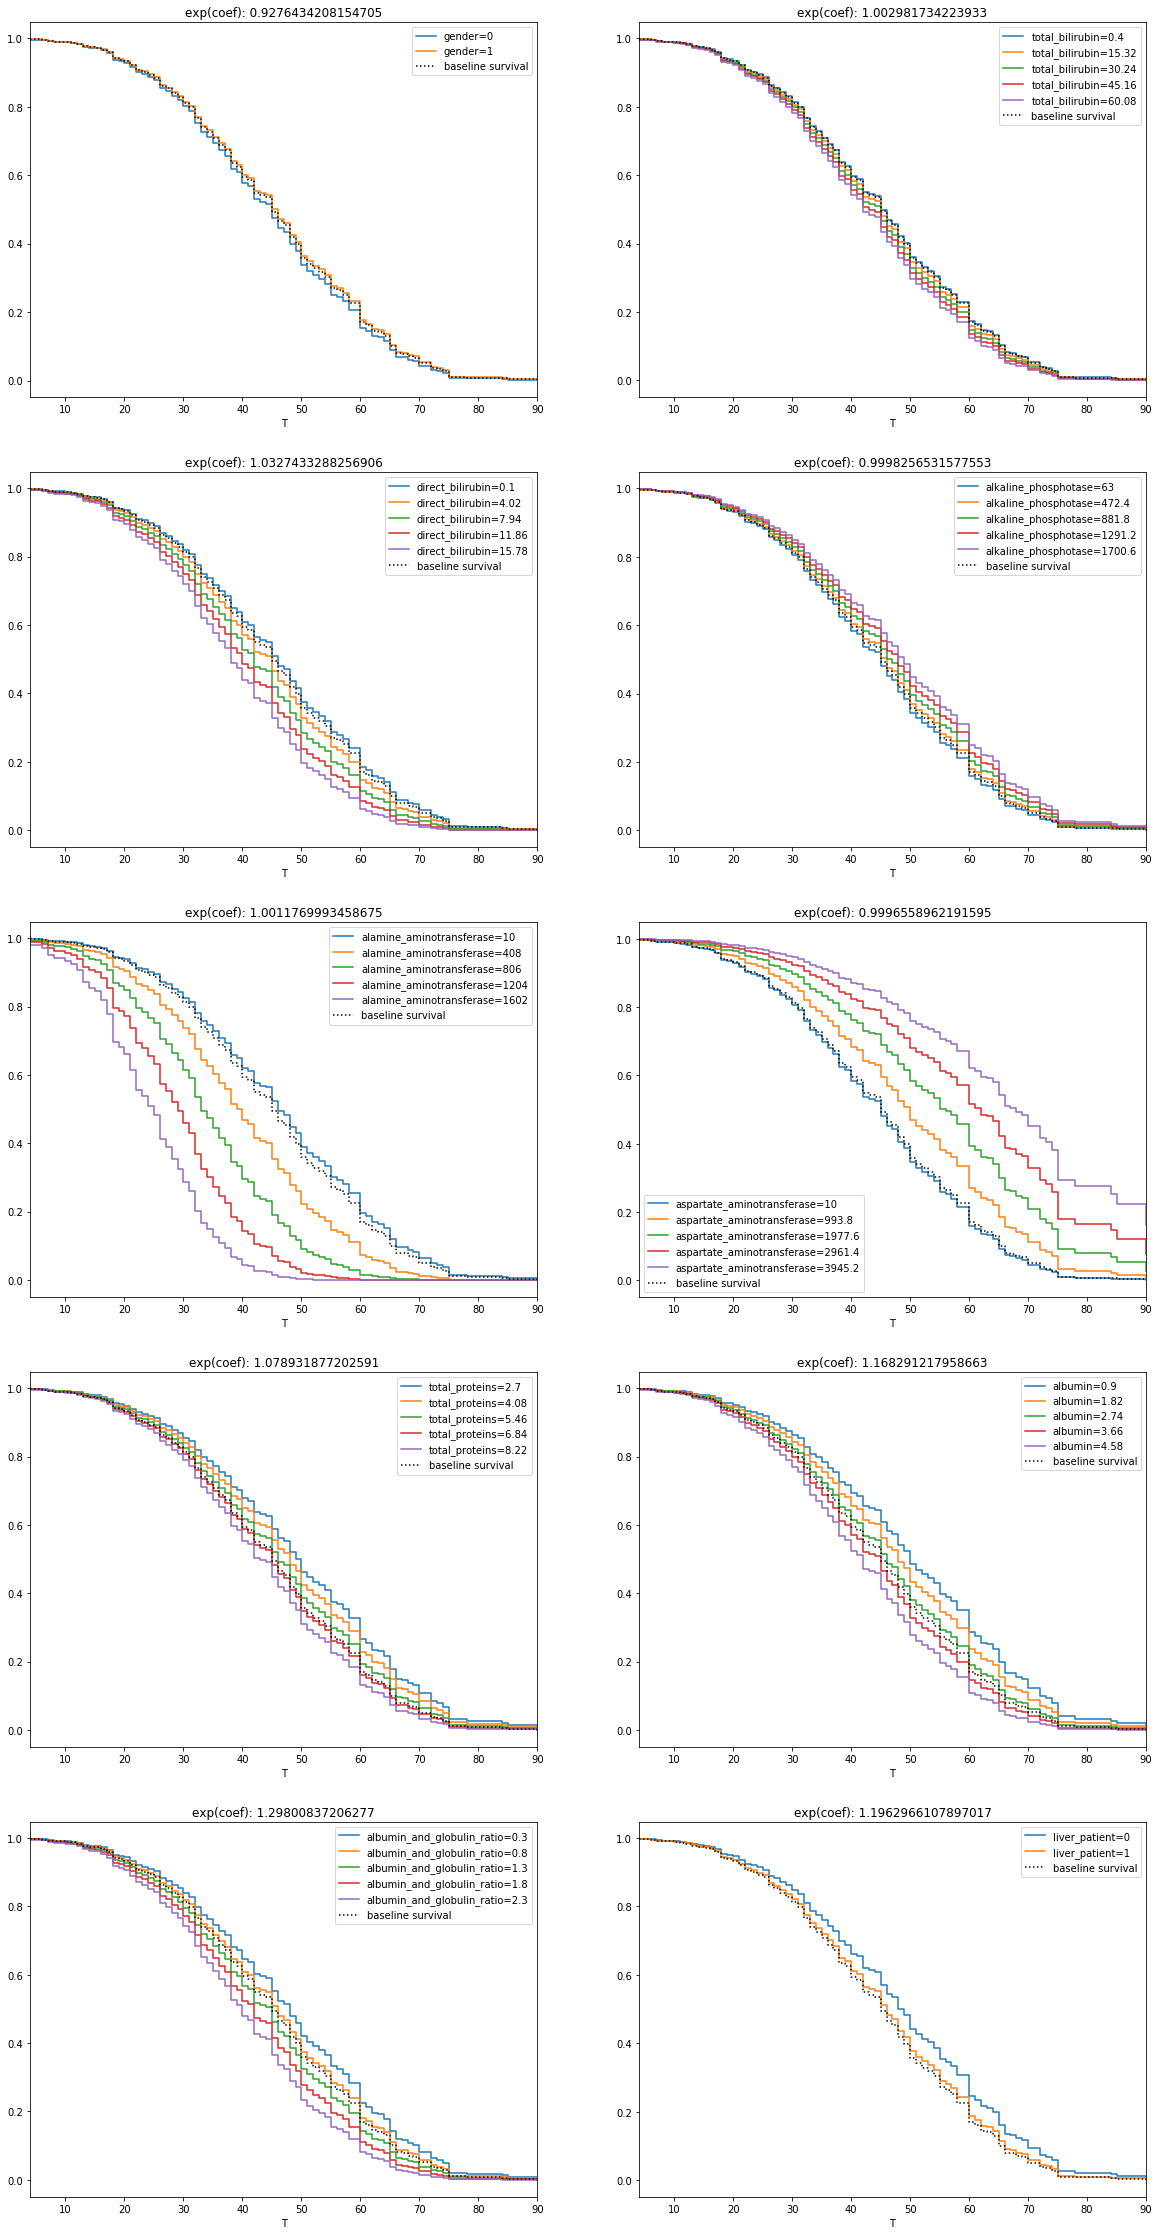

In [53]:
vars_to_isolate = data.drop(['dummy_category', 'age', 'observed'], axis=1).columns.values

ncols = 2
nrows = int(np.ceil(len(vars_to_isolate)*(1./ncols)))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20,40))

for ivar, var in enumerate(vars_to_isolate):
    if len(data[var].unique()) == 2:
        range_of_values = [0, 1]
    else:
        range_of_values = np.arange(data[var].min(), data[var].max(), (data[var].max()-data[var].min())/5)
    x1, x2 = divmod(ivar, ncols)
    cpf.plot_covariate_groups(var, range_of_values, ax=axes[x1, x2])
    axes[x1, x2].set_title(f'exp(coef): {cpf.summary.loc[var, "exp(coef)"]}')
plt.show()